In [18]:
import re
import sys
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('scripts/')

from utils import clean_title
from utils import get_representative_description
from utils import create_graph
from utils import sort_nodes_by_degree_centrality
from utils import determine_edge_weights
from utils import visualize_graph

# Configuración de opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 255)

# Lectura del archivo CSV de noticias
df = pd.read_csv("data/noticias-etiquetadas2.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.drop(df[df['Topic'] == -1].index, inplace=True)

df = clean_title(df)
df.drop_duplicates(subset=['title'], inplace=True)

# Imprimir el número de noticias en los meses Enero y Febrero de 2022
print("Número de noticias en los meses Enero y Febrero de 2022:", len(df))
df.head(2)

Número de noticias en los meses Enero y Febrero de 2022: 1721


,id_news,country,media_outlet,url,title,text,date,cities,keywords,Document,Topic,Probability
1,47719086.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/25/tractocamion-volco-esta-manana-en-puente-llollelhue-por-la-ruta-5-sur/,Tractocamión volcó esta mañana en puente Llollelhue por la ruta 5 Sur,"El accidente se produjo pasadas las 06:00 AM y no se lamentaron víctimas fatales. Esta mañana, en el km 868 de la ruta 5 Sur, con dirección norte a sur, un tractocamión cargado con alimento para mascotas chocó contra el puente Llollelhue para posterio...",2022-01-25,[],"['puente', 'victimas', 'bomberos', 'semi remolque', 'alimento']",tractocamion volco esta manana en puente llollelhue por la ruta sur el accidente se produjo pasadas las am y no se lamentaron victimas fatales esta manana en el km de la ruta sur con direccion norte a sur un tractocamion cargado con alimento para...,0,1.000000
2,47719110.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/27/gobernadores-regionales-de-los-rios-y-los-lagos-participaron-de-encuentro-birregional-en-rio-bueno/,Gobernadores Regionales de Los Ríos y Los Lagos participaron de Encuentro Birregional en Río Bueno,"La instancia buscó generar un trabajo colaborativo-asociativo entre ambos territorios, que permita avanzar hacia un desarrollo sustentable. El gobernador regional de Los Ríos, Luis Cuvertino, junto al gobernador regional de Los Lagos, Patricio Vallesp...",2022-01-27,"['los lagos', 'rio bueno']","['gobernadores', 'ambas regiones', 'puyehue', 'turismo', 'biosfera']",gobernadores regionales de los rios y los lagos participaron de encuentro birregional en rio bueno la instancia busco generar un trabajo colaborativoasociativo entre ambos territorios que permita avanzar hacia un desarrollo sustentable el gobernador ...,15,0.839193


In [19]:
# Lectura del archivo CSV de clusters
clusters = pd.read_csv("data/clusters2.csv")
clusters.drop(columns=["Unnamed: 0", "Name", "Representative_Docs"], inplace=True)
clusters.drop(clusters[clusters['Topic'] == -1].index, inplace=True)

clusters["Representation"] = clusters.Representation.apply(get_representative_description)
clusters

,Topic,Count,Representation
1,0,155,Accidentes en ruta en Chile
2,1,73,Proyecto de vivienda en Chile
3,2,72,Incendio en la Región Metropolitana
4,3,68,Crisis de niebla en Valparaíso
5,4,63,Teatro en Chile
6,5,47,Drogas en Chile
7,6,40,Desafíos de la gestión de obras públicas
8,7,39,Comercio y acción empresarial en Chile
9,8,36,Desafíos de la Educación
10,9,36,Tormentas electricas en Chile


<a>

## 1. Análisis de noticias en cluster mediante conexiones a través de sus keywords


Para este análisis se selecciona uno de los 71 clusteres.

Para este análisis nos concentraremos en un cluster específico: N°21 - "Financiamiento Municipal en Chile".
Este cluster presenta las noticias que se muestran a continuación.

En las siguientes celdas de código se construirá un grafo:
- Nodos: Los nodos son las noticias del cluster.
- Aristas: Son las keywords que las noticias tienen en común.

Puesto que son noticias de un mismo cluster, se espera obtener sectores del cluster que tratan el mismo hecho causal y otros que tratan hechos aledaños. 
    
</a>

In [20]:
df.loc[df.Topic == 21][['title', 'keywords']]

,title,keywords
73,En Panguipulli invertirán $ 615 millones en obras de pavimentación participativa - Diario Laguino,"['urbanismo proyecto', 'millones', 'jazmines lago pellaifa', 'calidad', 'inversion']"
161,"Anuncian pavimentación de 12,5 kilómetros de calles, pasajes y veredas de Los Ríos - Diario de Valdivia","['rios ignacio', 'urbanismo', 'pesos', 'mil millones', 'inversion']"
166,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia - Diario de Valdivia","['municipalidades', 'chilecompras servicio', 'hotel', 'impuestos', 'carampangue']"
197,Cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua - Diario Laguino,"['aguas', 'plan piloto', 'municipalidad', 'deficit', 'reunion']"
245,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia - Diario Laguino","['municipalidades', 'chilecompras servicio', 'hotel', 'basura costos', 'carampangue']"
262,La Unión: alcalde y dirigentas sostienen reunión con ministra de Transportes y Telecomunicaciones por barcaza de Llancacura,"['alcaldes', 'santiago', 'viajes', 'reunion', 'telecomunicaciones']"
347,Valdivia: autoridades y funcionarios municipales de todo el país se reunirán para abordar el escenario de las Finanzas Municipales,"['municipalidades', 'presupuesto', 'chilecompras servicio', 'hotel', 'carampangue']"
401,"Corporación Municipal anuncia auditoría interna para evaluar gestión administrativa, financiera y contable","['administracion', 'presupuestarios', 'transparencia', 'seis meses', 'reunion']"
405,En Panguipulli invertirán $ 615 millones en obras de pavimentación participativa,"['urbanismo proyecto', 'pesos', 'millones', 'jazmines lago pellaifa', 'inversion']"
653,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia para abordar el complejo escenario de las Finanzas Municipales","['municipalidades', 'chilecompras servicio', 'presupuesto', 'hotel', 'carampangue']"


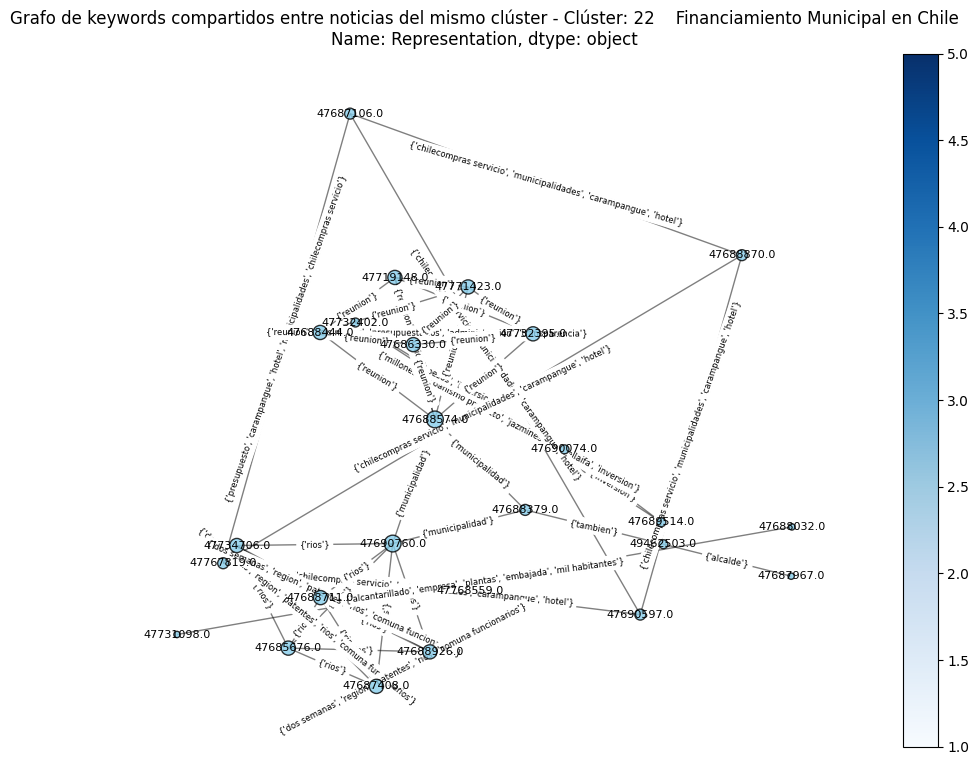

In [21]:
from utils import shared_keywords_of_news_in_cluster

graph = shared_keywords_of_news_in_cluster(df, clusters, cluster_num=21)
graph

<a>

El grafo obtenido muestra resultados interesantes:
1. Los conectores que vinculan más noticias son "reunión" y "rios".
2. Existen 3 noticias que presentan relaciones en más de un keyword. Se infiere que pueden ser noticias duplicadas.
    
</a>

In [22]:
ids = [47767819.0, 47690597.0, 47687106.0]
df.loc[df['id_news'].isin(ids)]

,id_news,country,media_outlet,url,title,text,date,cities,keywords,Document,Topic,Probability
166,47690597.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/actualidad/2022/01/alcaldes-concejales-y-funcionarios-municipales-de-todo-el-pais-se-reuniran-en-valdivia,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia - Diario de Valdivia","Desde el 17 al 21 de enero de 2022, se realizará en la ciudad de Valdivia el curso de “Finanzas Municipales y Desarrollo Sustentable”, orientado especialmente a autoridades locales y funcionarios municipales. En este curso, los participantes de la Esc...",2022-01-10,['valdivia'],"['municipalidades', 'chilecompras servicio', 'hotel', 'impuestos', 'carampangue']",alcaldes concejales y funcionarios municipales de todo el pais se reuniran en valdivia diario de valdivia desde el al de enero de se realizara en la ciudad de valdivia el curso de finanzas municipales y desarrollo sustentable orientado especialme...,21,1.0
347,47687106.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/11/valdivia-autoridades-y-funcionarios-municipales-de-todo-el-pais-se-reuniran-para-abordar-el-escenario-de-las-finanzas-municipales/,Valdivia: autoridades y funcionarios municipales de todo el país se reunirán para abordar el escenario de las Finanzas Municipales,"Desde el 17 al 21 de enero de 2022, se realizará en la ciudad de Valdivia el curso de “Finanzas Municipales y Desarrollo Sustentable”, orientado especialmente a autoridades locales y funcionarios municipales. En este curso, los participantes de la Esc...",2022-01-11,['valdivia'],"['municipalidades', 'presupuesto', 'chilecompras servicio', 'hotel', 'carampangue']",valdivia autoridades y funcionarios municipales de todo el pais se reuniran para abordar el escenario de las finanzas municipales desde el al de enero de se realizara en la ciudad de valdivia el curso de finanzas municipales y desarrollo sustentab...,21,1.0
653,47767819.0,chile,suractual,https://www.suractual.cl/2022/01/11/alcaldes-concejales-y-funcionarios-municipales-de-todo-el-pais-se-reuniran-en-valdivia-para-abordar-el-complejo-escenario-de-las-finanzas-municipales/,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia para abordar el complejo escenario de las Finanzas Municipales","Desde el 17 al 21 de enero de 2022, se realizará en la ciudad de Valdivia el curso de “Finanzas Municipales y Desarrollo Sustentable”, orientado especialmente a autoridades locales y funcionarios municipales. En este curso, los participantes de la Es...",2022-01-11,['valdivia'],"['municipalidades', 'chilecompras servicio', 'presupuesto', 'hotel', 'carampangue']",alcaldes concejales y funcionarios municipales de todo el pais se reuniran en valdivia para abordar el complejo escenario de las finanzas municipales desde el al de enero de se realizara en la ciudad de valdivia el curso de finanzas municipales y ...,21,1.0


Sorted Nodes: [47688574.0, 47690760.0, 47719148.0, 47732395.0, 47771423.0, 47688444.0, 47688711.0, 47685676.0, 47734706.0, 47687408.0, 47686330.0, 47688926.0, 47690597.0, 47688870.0, 47687106.0, 47767819.0, 47688379.0, 47689514.0, 47690074.0, 47732402.0, 49462503.0, 47687967.0, 47731098.0, 47688032.0, 47768559.0]


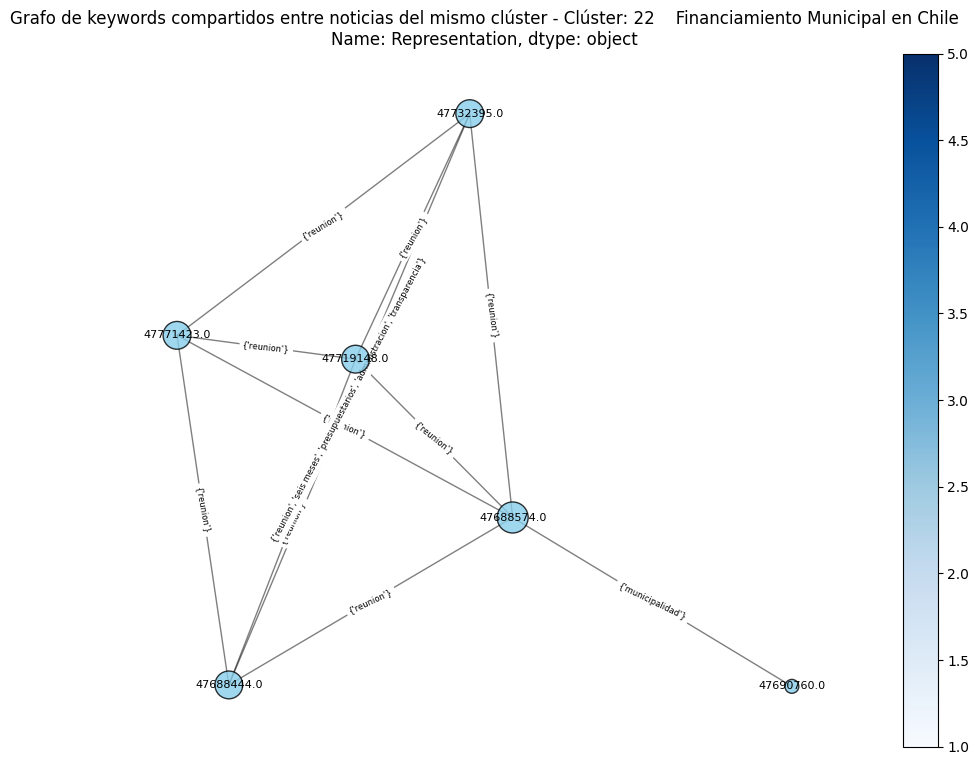

In [27]:
# Create the graph
graph = create_graph(df[df['Topic'] == 21])

# Sort nodes by degree centrality
sorted_nodes = sort_nodes_by_degree_centrality(graph)

# Use the sorted nodes for further analysis or customization
print("Sorted Nodes:", sorted_nodes)

ids = sorted_nodes[:6]
filtered_rows = df[df['id_news'].isin(ids)]
graph = create_graph(filtered_rows)
determine_edge_weights(graph)
visualize_graph(graph, filtered_rows, clusters, 21)

In [24]:
df.loc[df['id_news'].isin(ids)]

,id_news,country,media_outlet,url,title,text,date,cities,keywords,Document,Topic,Probability
197,47688574.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualidad/2022/01/cehum-y-municipio-laguino-proyectan-generar-plan-piloto-para-el-cuidado-del-agua,Cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua - Diario Laguino,"Como una forma de atender y hacerse cargo de la problemática que vive nuestro país respecto al tema del déficit hídrico que nos aqueja, el municipio de Los Lagos ha realizado un par de reuniones con el Centro de Humedales Río Cruces, institución de re...",2022-01-16,['los lagos'],"['aguas', 'plan piloto', 'municipalidad', 'deficit', 'reunion']",cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua diario laguino como una forma de atender y hacerse cargo de la problematica que vive nuestro pais respecto al tema del deficit hidrico que nos aqueja el municipio de lo...,21,1.000000
262,47719148.0,chile,noticiaslosrios,https://www.noticiaslosrios.cl/2022/01/18/la-union-alcalde-y-dirigentas-sostienen-reunion-con-ministra-de-transportes-y-telecomunicaciones-por-barcaza-de-llancacura/,La Unión: alcalde y dirigentas sostienen reunión con ministra de Transportes y Telecomunicaciones por barcaza de Llancacura,"La reunión se llevó a cabo en el Ministerio de Transportes y Comunicaciones en Santiago y estuvieron presentes el diputado Iván Flores, los alcaldes de San Pablo y La Unión, además de dirigentas del sector. El alcalde de La Unión, Andrés Reinoso, junt...",2022-01-18,['los lagos'],"['alcaldes', 'santiago', 'viajes', 'reunion', 'telecomunicaciones']",la union alcalde y dirigentas sostienen reunion con ministra de transportes y telecomunicaciones por barcaza de llancacura la reunion se llevo a cabo en el ministerio de transportes y comunicaciones en santiago y estuvieron presentes el diputado ivan...,21,0.956759
401,47732395.0,chile,centralnoticiaspanguipulli,https://centralnoticias.cl/corporacion-municipal-anuncia-auditoria-interna-para-evaluar-gestion-administrativa-financiera-y-contable/,"Corporación Municipal anuncia auditoría interna para evaluar gestión administrativa, financiera y contable","En la primera reunión de directorio del año de la Corporación Municipal de Panguipulli (Cormupa), se tomó la decisión de generar una auditoría integral externa, que evalúe la gestión administrativa, financiera y contable de la corporación, de los años...",2022-01-19,['panguipulli'],"['administracion', 'presupuestarios', 'transparencia', 'seis meses', 'reunion']",corporacion municipal anuncia auditoria interna para evaluar gestion administrativa financiera y contable en la primera reunion de directorio del ano de la corporacion municipal de panguipulli cormupa se tomo la decision de generar una auditoria inte...,21,1.000000
661,47771423.0,chile,suractual,https://www.suractual.cl/2022/01/10/gobernador-diaz-se-reunio-con-representantes-del-sector-productivo-de-contulmo/,Gobernador Díaz se reunió con representantes del sector productivo de Contulmo,"Alcalde Carlos Leal Neira recibió a gobernador regional Rodrigo Díaz Wörner Durante la tarde de este jueves alcalde Carlos Leal Neira, recibió al gobernador regional del Biobío, Rodrigo Díaz Wörner, en dependencias municipales. Las autoridades llevar...",2022-01-10,[],"['gobernador', 'sector', 'reunion', 'vivienda', 'biobio']",gobernador diaz se reunio con representantes del sector productivo de contulmo alcalde carlos leal neira recibio a gobernador regional rodrigo diaz worner durante la tarde de este jueves alcalde carlos leal neira recibio al gobernador regional del b...,21,0.956759
884,47688444.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualidad/2022/01/cormupa-anuncia-auditoria-interna-para-evaluar-gestion-administrativa-financiera-y-contable,"Cormupa anuncia auditoría interna para evaluar gestión administrativa, financiera y contable - Diario Laguino","En la primera reunión de directorio del

## 2. Análisis de sectores y sus clusters considerando las keywords de sus noticias

#### Agrupación de clusters en sectores de interés

- Grupo 1: Salud
[0, 3, 5, 12, 17, 24, 25, 26, 31, 35, 43, 52, 54, 55]

- Grupo 2: Economía y Negocios
[1, 6, 7, 8, 11, 18, 21, 22, 28, 49, 50, 61]

- Grupo 3: Medio Ambiente
[2, 10, 15, 9, 19, 20, 34, 62, 63, 64]

- Grupo 4: Educación
[4, 8, 16]

- Grupo 5: Otros
[14, 13, 23, 30, 27, 29, 32, 33, 36, 46, 47, 48, 56, 57, 58, 60, 65, 66, 67]

In [ ]:
from utils import extract_keywords

# Crear una función para combinar listas sin duplicados
def combine_lists(list_of_lists):
    combined_list = list(set([item for sublist in list_of_lists for item in sublist]))
    return combined_list

# Crear una lista de listas de keywords por cluster
keywords_by_cluster = []
for cluster_num in clusters['Topic']:
    list_of_lists = []
    for elem in df.loc[df.Topic == cluster_num, 'keywords'].tolist():
        list_of_lists.append(extract_keywords(elem))
    combined_list = combine_lists(list_of_lists)
    keywords_by_cluster.append(combined_list)

# Agregar la columna 'keywords' al DataFrame clusters
clusters['keywords'] = keywords_by_cluster

In [ ]:
salud = [0, 3, 12, 17, 24, 25, 26, 31, 35, 43, 52, 54, 55, 64]
economia = [1, 6, 7, 8, 11, 18, 21, 22, 28, 49, 50, 61]
medio_ambiente = [2, 10, 15, 9, 19, 20, 34, 62, 63]
educacion = [4, 8, 16]

clusters_salud = clusters[clusters['Topic'].isin(salud)]
clusters_economia = clusters[clusters['Topic'].isin(economia)]
clusters_medio_ambiente = clusters[clusters['Topic'].isin(medio_ambiente)]
clusters_educacion = clusters[clusters['Topic'].isin(educacion)]

sectores = [clusters_salud, clusters_economia, clusters_medio_ambiente, clusters_educacion]    

In [ ]:
clusters_medio_ambiente

In [ ]:
from utils import keyword_distribution
from utils import generate_graph_from_dataframe

generate_graph_from_dataframe(clusters_medio_ambiente)  # Llamar a la función para generar el gráfico
keyword_distribution(clusters_medio_ambiente)  # Llamar a la función para generar el gráfico

## 3. Análisis de sector vs sector (salud vs medioambiente)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un nuevo grafo
grafo = nx.Graph()

# Agregar nodos del dataframe clusters_medio_ambiente (verdes)
for i, fila in clusters_medio_ambiente.iterrows():
    topic = fila['Topic']
    keywords = fila['keywords']
    grafo.add_node(topic, color='green', keywords=keywords)

# Agregar nodos del dataframe clusters_educación (rojos)
for i, fila in clusters_educacion.iterrows():
    topic = fila['Topic']
    keywords = fila['keywords']
    grafo.add_node(topic, color='red', keywords=keywords)

# Agregar aristas entre nodos según las condiciones
for nodo1, attr1 in grafo.nodes(data=True):
    color1 = attr1['color']
    keywords1 = attr1['keywords']
    
    for nodo2, attr2 in grafo.nodes(data=True):
        color2 = attr2['color']
        keywords2 = attr2['keywords']
        
        if color1 != color2 and any(keyword in keywords2 for keyword in keywords1):
            grafo.add_edge(nodo1, nodo2)

# Obtener colores y keywords de los nodos
colores_nodos = [attr['color'] for _, attr in grafo.nodes(data=True)]
keywords_nodos = [attr['keywords'] for _, attr in grafo.nodes(data=True)]

# Dibujar los nodos con colores diferentes y etiquetas de keywords
nodos_verdes = [nodo for nodo, attr in grafo.nodes(data=True) if attr['color'] == 'green']
nodos_rojos = [nodo for nodo, attr in grafo.nodes(data=True) if attr['color'] == 'red']

posiciones = nx.random_layout(grafo)
nx.draw_networkx_nodes(grafo, pos=posiciones, nodelist=nodos_verdes, node_color='green')
nx.draw_networkx_nodes(grafo, pos=posiciones, nodelist=nodos_rojos, node_color='red')

# Dibujar las aristas
nx.draw_networkx_edges(grafo, pos=posiciones)

# Agregar etiquetas a los nodos con las keywords
etiquetas = {nodo: ', '.join(keywords) for nodo, keywords in zip(grafo.nodes, keywords_nodos)}
nx.draw_networkx_labels(grafo, pos=posiciones, labels=etiquetas, font_size=8, verticalalignment='bottom')

# Mostrar el grafo
plt.axis('off')
plt.show()
